In [ ]:
import os
import cv2
import numpy as np
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from google.colab import drive
from zipfile import ZipFile

In [ ]:
google_drive_mount_path = '/content/drive'
drive.mount(google_drive_mount_path)

Mounted at /content/drive


In [ ]:
# Create directory for dataset (using clearer variable name)
dataset_dir = '/content/dataset'
!mkdir -p {dataset_dir}

# Download dataset with descriptive filename variable
dataset_zip_url = 'https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip'
dataset_zip_path = '/content/kagglecatsanddogs_5340.zip'
!wget -P /content/ {dataset_zip_url}

# Extract with clear context
with ZipFile(dataset_zip_path, 'r') as dataset_zip:
    dataset_zip.extractall(dataset_dir)

--2025-07-16 14:07:01--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.192.208.155, 2600:1409:3c00:c80::317f, 2600:1409:3c00:c8c::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.192.208.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘/content/kagglecatsanddogs_5340.zip’

kagglecatsanddogs_5 100%[===================>] 786.67M   163MB/s    in 8.7s    

2025-07-16 14:07:10 (90.4 MB/s) - ‘/content/kagglecatsanddogs_5340.zip’ saved [824887076/824887076]



In [ ]:
# Define paths using descriptive variables
dataset_root = '/content/dataset'
min_file_size = '10k'  # 10 kilobytes minimum size threshold

# Clean dataset by removing corrupt/small images (JPEGs under 10KB)
!find {dataset_root} -type f -name "*.jpg" -size -{min_file_size} -delete

In [ ]:
# Constants with clear naming
IMAGE_SIZE = 128  # Target size for resizing images
HOG_ORIENTATIONS = 9
HOG_PIXELS_PER_CELL = (8, 8)
HOG_CELLS_PER_BLOCK = (2, 2)
MAX_SAMPLES_PER_CLASS = 2000  # Limit samples per class to manage memory usage

def load_image_data():
    """Load and process image data with HOG feature extraction.

    Returns:
        list: A list of tuples containing (HOG_features, class_label) for each image
    """
    processed_data = []
    dataset_base_path = '/content/dataset/PetImages'

    for animal_class in ['Cat', 'Dog']:  # Matching folder names exactly
        class_path = os.path.join(dataset_base_path, animal_class)
        class_label = 0 if animal_class == 'Cat' else 1
        processed_count = 0

        for image_file in os.listdir(class_path):
            if processed_count >= MAX_SAMPLES_PER_CLASS:
                break

            try:
                image_path = os.path.join(class_path, image_file)
                original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

                if original_image is None:
                    continue  # Skip corrupt/invalid images

                # Resize and preprocess image
                resized_image = cv2.resize(original_image, (IMAGE_SIZE, IMAGE_SIZE))

                # Extract HOG features
                hog_features = hog(
                    resized_image,
                    orientations=HOG_ORIENTATIONS,
                    pixels_per_cell=HOG_PIXELS_PER_CELL,
                    cells_per_block=HOG_CELLS_PER_BLOCK,
                    visualize=False,
                    feature_vector=True
                )

                processed_data.append((hog_features, class_label))
                processed_count += 1

            except Exception as e:
                # Log error if needed: print(f"Error processing {image_path}: {e}")
                continue

    return processed_data

In [ ]:
def preprocess_data(labeled_features):
    """Separate features and labels, and optionally apply scaling/normalization.

    Args:
        labeled_features (list): List of tuples containing (features, label)

    Returns:
        tuple: (features_array, labels_array) as NumPy arrays
    """
    # Unpack features and labels with descriptive names
    features_list = [feature_vector for feature_vector, _ in labeled_features]
    labels_list = [class_label for _, class_label in labeled_features]

    # Convert to NumPy arrays
    feature_matrix = np.array(features_list)
    label_vector = np.array(labels_list)

    return feature_matrix, label_vector

Starting image classification pipeline...

1. Loading image data...
Loaded 4000 samples (2000 per class)

2. Preprocessing data...
Feature dimension after PCA: 1588

3. Training model...

Training SVM classifier...
[LibSVM]
Training completed in 6.71 seconds
Test Accuracy: 0.7362

Detailed Classification Report:
              precision    recall  f1-score   support

         Cat     0.7182    0.7775    0.7467       400
         Dog     0.7575    0.6950    0.7249       400

    accuracy                         0.7362       800
   macro avg     0.7379    0.7362    0.7358       800
weighted avg     0.7379    0.7362    0.7358       800


4. Visualizing HOG features...


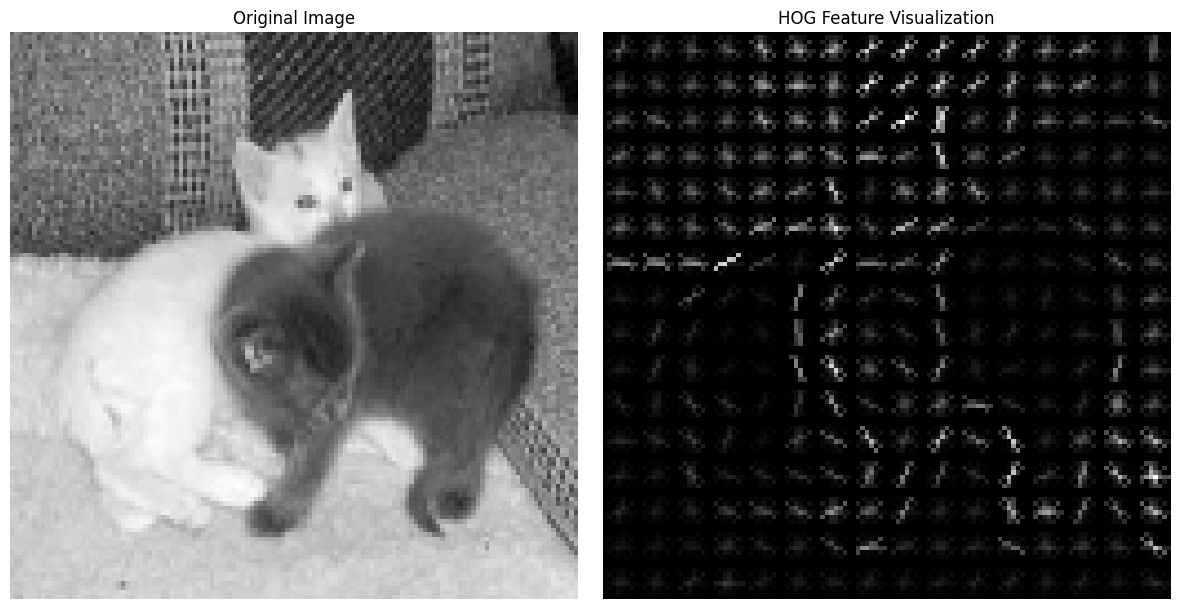

In [ ]:
def preprocess_data(labeled_features):
    """Preprocess the dataset by standardizing features and applying PCA.

    Args:
        labeled_features (list): List of (features, label) tuples

    Returns:
        tuple: (processed_features, labels, pca_model, scaler)
    """
    # Unpack features and labels
    features = np.array([features for features, _ in labeled_features])
    labels = np.array([label for _, label in labeled_features])

    # Standardize features
    feature_scaler = StandardScaler()
    standardized_features = feature_scaler.fit_transform(features)

    # Apply PCA for dimensionality reduction
    pca_model = PCA(n_components=0.95)  # Keep 95% of variance
    reduced_features = pca_model.fit_transform(standardized_features)

    return reduced_features, labels, pca_model, feature_scaler


def train_svm(features, labels):
    """Train and evaluate an SVM classifier.

    Args:
        features (np.array): Processed feature vectors
        labels (np.array): Corresponding class labels

    Returns:
        SVC: Trained SVM model
    """
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        features, labels,
        test_size=0.2,
        random_state=42,
        stratify=labels  # Maintain class distribution
    )

    # Create and train SVM classifier
    svm_classifier = SVC(
        kernel='rbf',
        C=1.0,
        gamma='scale',
        random_state=42,
        verbose=True  # Show training progress
    )

    print("\nTraining SVM classifier...")
    start_time = time.time()
    svm_classifier.fit(X_train, y_train)
    training_time = time.time() - start_time

    # Evaluate model
    y_pred = svm_classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(
        y_test,
        y_pred,
        target_names=['Cat', 'Dog'],
        digits=4
    )

    # Print performance metrics
    print(f"\nTraining completed in {training_time:.2f} seconds")
    print(f"Test Accuracy: {accuracy:.4f}")
    print("\nDetailed Classification Report:")
    print(class_report)

    return svm_classifier


def visualize_hog_features():
    """Visualize HOG features for a sample image."""
    # Load sample image
    sample_dir = os.path.join(dataset_root, 'PetImages', 'Cat')
    sample_image = os.listdir(sample_dir)[0]
    image_path = os.path.join(sample_dir, sample_image)

    original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if original_image is None:
        print("Error: Could not load sample image for visualization")
        return

    # Preprocess image
    processed_image = cv2.resize(original_image, (IMAGE_SIZE, IMAGE_SIZE))

    # Compute HOG features
    hog_features, hog_visualization = hog(
        processed_image,
        orientations=HOG_ORIENTATIONS,
        pixels_per_cell=HOG_PIXELS_PER_CELL,
        cells_per_block=HOG_CELLS_PER_BLOCK,
        visualize=True,
        feature_vector=True
    )

    # Create visualization
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(processed_image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(hog_visualization, cmap='gray')
    plt.title('HOG Feature Visualization')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


def main():
    """Main execution pipeline."""
    print("Starting image classification pipeline...")

    # Load data
    print("\n1. Loading image data...")
    image_data = load_image_data()
    print(f"Loaded {len(image_data)} samples ({len(image_data)//2} per class)")

    # Preprocess data
    print("\n2. Preprocessing data...")
    features, labels, pca, scaler = preprocess_data(image_data)
    print(f"Feature dimension after PCA: {features.shape[1]}")

    # Train model
    print("\n3. Training model...")
    trained_model = train_svm(features, labels)

    # Visualize features
    print("\n4. Visualizing HOG features...")
    visualize_hog_features()


if __name__ == "__main__":
    import time  # For tracking training time
    main()